In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import model_function
import math
import keras

In [176]:
(_, y_values), (_, y_values_test) = keras.datasets.mnist.load_data()

Load a model or create a new one?

In [177]:
load = False
model_path ='models/2024-01-08_14-17-45_3exp_params_517_points_50/model.keras'

In [252]:
#normal image
# X_data = np.load(f'outputs/x_train_current_normal.npy')
# X_data = X_data[:,:,-1]


#linearized image
X_data_linearized = np.load(f'outputs/x_train_current_linearized.npy')
X_data_spiral = np.load(f'outputs/x_train_current_spiral.npy')
# X_data = np.stack([X_data_linearized[:60000],X_data_spiral], axis = 2)
X_data = X_data_linearized[:,::28]
# X_data = X_data[:,-1]
# X_data = np.expand_dims(X_data, axis = 1)


print(X_data.shape)

(60000, 28)


In [253]:
# y_values= np.load(f'outputs/y_train_{60000}.npy')
y_data= np.zeros((y_values.shape[0], 10))
for i in range(y_values.shape[0]):
    y_data[i,y_values[i]]=1
y_data = y_data[:X_data.shape[0]]
y_data.shape

(60000, 10)

In [254]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, train_size=0.7)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, train_size=0.5)
X_train.shape

(42000, 28)

In [255]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# y_train = scaler.fit_transform(y_train)
# y_val = scaler.transform(y_val)
# y_test = scaler.transform(y_test)

## 28x28 network

In [163]:
import keras

import tensorflow.keras.backend as K



def create_nn(dropout_rate=0.5):
    global X_train, points
    # Input layer, the number of input nodes is governed by X_data.shape[1]
    # X_data.shape[1] is the number of columns in X_data
    inputs = keras.Input(shape=(X_train.shape[1],), name='input')
    x = inputs
    # Dense layers 
    #layers_norm = keras.layers.BatchNormalization()(inputs)
    dropout_layer = False
    params_per_layer = 500
    number_of_layers = 1
    for i in range(number_of_layers):    
        x = keras.layers.Dense(params_per_layer, 'relu')(x)
        if dropout_layer:
            x = keras.layers.Dropout(rate=dropout_rate)(x)

    
    
    # Parameter layer
    # layers_norm = keras.layers.LayerNormalization()(layers_dense2)
    output = keras.layers.Dense(10, activation = 'sigmoid')(x)
    # Expand parameters to have same shape as y_true
    # expanded_parameters = keras.layers.RepeatVector(points)(parameters)


    return keras.Model(inputs=inputs, outputs=output, name="number_classifier")

In [164]:
if load:
    model = keras.models.load_model(model_path)
else:
    model = create_nn(dropout_rate=0.1)

model.summary()

Model: "number_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28)]              0         
                                                                 
 dense_74 (Dense)            (None, 500)               14500     
                                                                 
 dense_75 (Dense)            (None, 10)                5010      
                                                                 
Total params: 19510 (76.21 KB)
Trainable params: 19510 (76.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [165]:
def compile_model(model):
    sgd = keras.optimizers.RMSprop(clipnorm=5)
    model.compile(optimizer='adam', #'sgd'
                  loss='binary_crossentropy',#'mse'
                  metrics = ['accuracy']
                  )
    


number_of_epochs = 500




earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss",baseline = 1, patience=number_of_epochs,restore_best_weights=False)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=20, 
                              min_lr=1e-8)
compile_model(model)

import seaborn as sns
def plot_history(history, metrics, y_lim):
    """
    Plot the training history

    Args:
        history (keras History object that is returned by model.fit())
        metrics (str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    if y_lim != 0:
        plt.ylim(0,y_lim)
    plt.xlabel("epochs")
    plt.ylabel("metric")



In [166]:
history = model.fit(X_train, y_train,
                    batch_size=1024,
                    epochs=number_of_epochs,
                    validation_data = (X_val,y_val),
                    callbacks=[earlystopper
                               ,reduce_lr
                               ],
                    verbose=2)

Epoch 1/500
42/42 - 1s - loss: 0.3400 - accuracy: 0.4824 - val_loss: 0.1995 - val_accuracy: 0.6362 - lr: 0.0010 - 677ms/epoch - 16ms/step
Epoch 2/500
42/42 - 0s - loss: 0.1769 - accuracy: 0.6679 - val_loss: 0.1611 - val_accuracy: 0.6964 - lr: 0.0010 - 128ms/epoch - 3ms/step
Epoch 3/500
42/42 - 0s - loss: 0.1537 - accuracy: 0.7082 - val_loss: 0.1472 - val_accuracy: 0.7163 - lr: 0.0010 - 127ms/epoch - 3ms/step
Epoch 4/500
42/42 - 0s - loss: 0.1423 - accuracy: 0.7315 - val_loss: 0.1385 - val_accuracy: 0.7324 - lr: 0.0010 - 121ms/epoch - 3ms/step
Epoch 5/500
42/42 - 0s - loss: 0.1348 - accuracy: 0.7471 - val_loss: 0.1321 - val_accuracy: 0.7480 - lr: 0.0010 - 126ms/epoch - 3ms/step
Epoch 6/500
42/42 - 0s - loss: 0.1290 - accuracy: 0.7603 - val_loss: 0.1270 - val_accuracy: 0.7599 - lr: 0.0010 - 127ms/epoch - 3ms/step
Epoch 7/500
42/42 - 0s - loss: 0.1243 - accuracy: 0.7711 - val_loss: 0.1229 - val_accuracy: 0.7671 - lr: 0.0010 - 124ms/epoch - 3ms/step
Epoch 8/500
42/42 - 0s - loss: 0.1204 - 

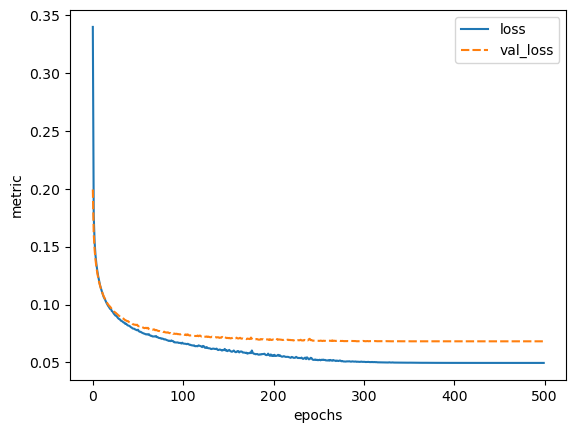

In [167]:
# call the plot_history function with the apropriate object and string
plot_history(history, ['loss'
                       , 'val_loss'
                       ]
                       ,0)

In [174]:
# # Save the model
# import os
# from datetime import datetime
# current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# # filename = f"{current_date}_RMSE_params_{model.count_params()}_points_{points}.keras"
# # model.save('models/'+filename)


# folder_path = f'models/{current_date}_time_dependant_MNIST_28x28'
# os.makedirs(folder_path, exist_ok=True)
# model.save(folder_path+'/model.keras')
# model.save(folder_path+'/model.h5')

c:\Users\crpdn\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [169]:
# make prediction on test data
y_train_prediction = model.predict(X_train)
y_test_prediction = model.predict(X_test)

282/282 [==============================] - 0s 828us/step


In [170]:
y_train_prediction_count = np.zeros((10,10))
for i in range(y_train_prediction.shape[0]):
    y_train_prediction_count[np.argmax(y_train_prediction[i]), np.argmax(y_train[i])] +=1

y_test_prediction_count = np.zeros((10,10))
for i in range(y_test_prediction.shape[0]):
    y_test_prediction_count[ np.argmax(y_test_prediction[i]),np.argmax(y_test[i])] +=1

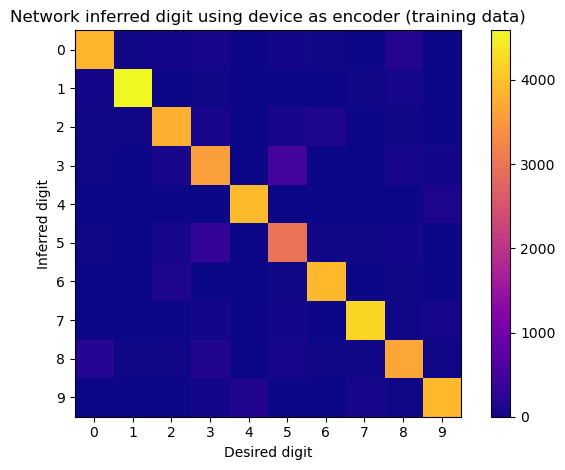

In [171]:
plt.imshow(y_train_prediction_count, cmap='plasma')
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.title('Network inferred digit using device as encoder (training data)')
plt.ylabel('Inferred digit')
plt.xlabel('Desired digit')
plt.tight_layout()
plt.show()

In [172]:
model.evaluate(X_test, y_test, verbose = 1)

282/282 [==============================] - 0s 1ms/step - loss: 0.0678 - accuracy: 0.8800


[0.06776688992977142, 0.8799999952316284]

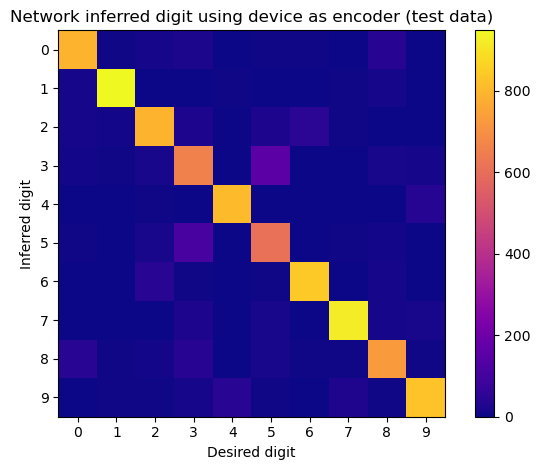

In [173]:
plt.imshow(y_test_prediction_count, cmap='plasma')
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.title('Network inferred digit using device as encoder (test data)')
plt.ylabel('Inferred digit')
plt.xlabel('Desired digit')
plt.tight_layout()
plt.show()

## Linearized network

In [267]:
import keras

import tensorflow.keras.backend as K



def create_nn(dropout_rate=0.5):
    global X_train, points
    # Input layer, the number of input nodes is governed by X_data.shape[1]
    # X_data.shape[1] is the number of columns in X_data
    inputs = keras.Input(shape=(X_train.shape[1],), name='input')
    x = inputs
    # Dense layers 
    #layers_norm = keras.layers.BatchNormalization()(inputs)
    dropout_layer = False
    params_per_layer = 500
    number_of_layers = 1
    for i in range(number_of_layers):    
        x = keras.layers.Dense(params_per_layer, 'relu')(x)
        if dropout_layer:
            x = keras.layers.Dropout(rate=dropout_rate)(x)

    
    
    # Parameter layer
    # layers_norm = keras.layers.LayerNormalization()(layers_dense2)
    output = keras.layers.Dense(10, activation = 'sigmoid')(x)
    # Expand parameters to have same shape as y_true
    # expanded_parameters = keras.layers.RepeatVector(points)(parameters)


    return keras.Model(inputs=inputs, outputs=output, name="number_classifier")

In [268]:
if load:
    model = keras.models.load_model(model_path)
else:
    model = create_nn(dropout_rate=0.1)

model.summary()

Model: "number_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28)]              0         
                                                                 
 dense_139 (Dense)           (None, 500)               14500     
                                                                 
 dense_140 (Dense)           (None, 10)                5010      
                                                                 
Total params: 19510 (76.21 KB)
Trainable params: 19510 (76.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [269]:
def compile_model(model):
    sgd = keras.optimizers.RMSprop(clipnorm=5)
    model.compile(optimizer='adam', #'sgd'
                  loss='binary_crossentropy',#'mse'
                  metrics = ['accuracy']
                  )
    


number_of_epochs = 500




earlystopper = keras.callbacks.EarlyStopping(monitor="val_loss",baseline = 1, patience=number_of_epochs,restore_best_weights=False)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.5, 
                              patience=20, 
                              min_lr=1e-8)
compile_model(model)

import seaborn as sns
def plot_history(history, metrics, y_lim):
    """
    Plot the training history

    Args:
        history (keras History object that is returned by model.fit())
        metrics (str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    if y_lim != 0:
        plt.ylim(0,y_lim)
    plt.xlabel("epochs")
    plt.ylabel("metric")



In [270]:
history = model.fit(X_train, y_train,
                    batch_size=1024,
                    epochs=number_of_epochs,
                    validation_data = (X_val,y_val),
                    callbacks=[earlystopper
                               ,reduce_lr
                               ],
                    verbose=2)

Epoch 1/500
42/42 - 1s - loss: 0.3408 - accuracy: 0.4674 - val_loss: 0.2109 - val_accuracy: 0.5934 - lr: 0.0010 - 856ms/epoch - 20ms/step
Epoch 2/500
42/42 - 0s - loss: 0.1888 - accuracy: 0.6293 - val_loss: 0.1723 - val_accuracy: 0.6667 - lr: 0.0010 - 155ms/epoch - 4ms/step
Epoch 3/500
42/42 - 0s - loss: 0.1643 - accuracy: 0.6778 - val_loss: 0.1571 - val_accuracy: 0.6993 - lr: 0.0010 - 237ms/epoch - 6ms/step
Epoch 4/500
42/42 - 0s - loss: 0.1522 - accuracy: 0.7048 - val_loss: 0.1478 - val_accuracy: 0.7221 - lr: 0.0010 - 168ms/epoch - 4ms/step
Epoch 5/500
42/42 - 0s - loss: 0.1437 - accuracy: 0.7259 - val_loss: 0.1409 - val_accuracy: 0.7374 - lr: 0.0010 - 150ms/epoch - 4ms/step
Epoch 6/500
42/42 - 0s - loss: 0.1374 - accuracy: 0.7413 - val_loss: 0.1354 - val_accuracy: 0.7520 - lr: 0.0010 - 143ms/epoch - 3ms/step
Epoch 7/500
42/42 - 0s - loss: 0.1325 - accuracy: 0.7511 - val_loss: 0.1310 - val_accuracy: 0.7612 - lr: 0.0010 - 149ms/epoch - 4ms/step
Epoch 8/500
42/42 - 0s - loss: 0.1284 - 

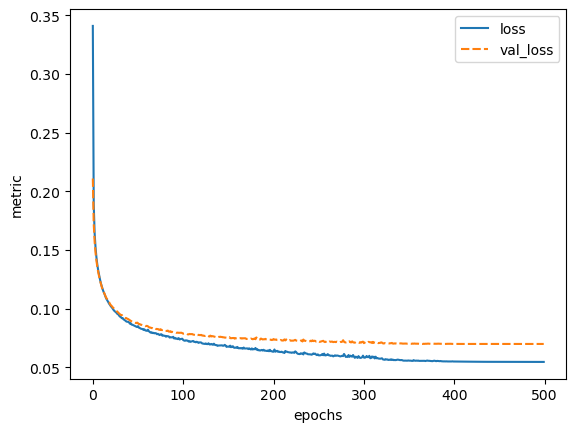

In [278]:
# call the plot_history function with the apropriate object and string
plot_history(history, ['loss'
                       , 'val_loss'
                       ]
                       ,0)

In [285]:
# # Save the model
# import os
# from datetime import datetime
# current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")



# folder_path = f'models/{current_date}_time_dependant_MNIST_linearized'
# os.makedirs(folder_path, exist_ok=True)
# model.save(folder_path+'/model.keras')
# model.save(folder_path+'/model.h5')

c:\Users\crpdn\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [280]:
# make prediction on test data
y_train_prediction = model.predict(X_train)
y_test_prediction = model.predict(X_test)

282/282 [==============================] - 0s 759us/step


In [281]:
y_train_prediction_count = np.zeros((10,10))
for i in range(y_train_prediction.shape[0]):
    y_train_prediction_count[np.argmax(y_train_prediction[i]), np.argmax(y_train[i])] +=1

y_test_prediction_count = np.zeros((10,10))
for i in range(y_test_prediction.shape[0]):
    y_test_prediction_count[ np.argmax(y_test_prediction[i]),np.argmax(y_test[i])] +=1

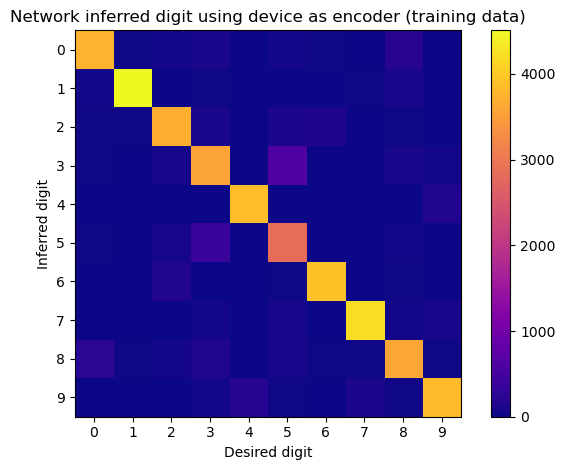

In [282]:
plt.imshow(y_train_prediction_count, cmap='plasma')
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.title('Network inferred digit using device as encoder (training data)')
plt.ylabel('Inferred digit')
plt.xlabel('Desired digit')
plt.tight_layout()
plt.show()

In [283]:
model.evaluate(X_test, y_test, verbose = 1)

282/282 [==============================] - 0s 864us/step - loss: 0.0678 - accuracy: 0.8774


[0.06781485676765442, 0.8774444460868835]

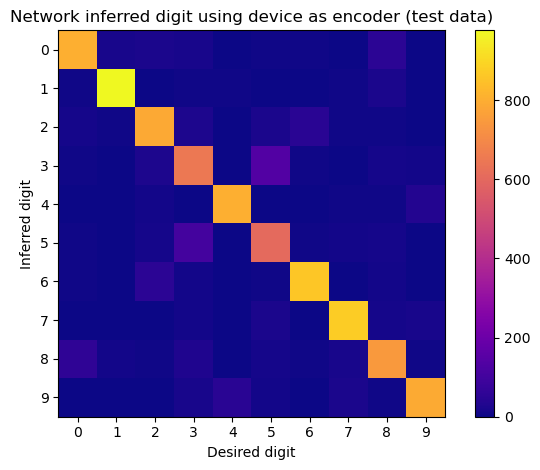

In [284]:
plt.imshow(y_test_prediction_count, cmap='plasma')
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.title('Network inferred digit using device as encoder (test data)')
plt.ylabel('Inferred digit')
plt.xlabel('Desired digit')
plt.tight_layout()
plt.show()